# Running Quantum Kernel SVM for Binary Classification on Qiskit #

## 1. Import libraries

1. Import classical libraries (for machine learning)

In [9]:
import sys
sys.path.append("Help Function")

import make_data
import classical_algo

import time
import tracemalloc
import os
import csv 

import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

2. Import quantum libraries

In [10]:
import pennylane as qml
from functools import lru_cache

## 2. Self - configure Feature Map

We will choose ZFeatureMap (PauliFeatureMap with paulis = ['Z'], alpha = 1.0, reps = 1)

The self-configure circuit will be based on circuit from Qiskit

In [11]:
dev = qml.device("default.qubit", wires=2)

def ZFeatureMap(x, reps = 1):
    for _ in range(reps):
        for i in range(2):
            qml.H(wires = i)
        for i in range(2):
            qml.PhaseShift(x[i], wires = i)

## 3. Hybrid algorithm (classical SVM + quantum kernel)

1. Help - function if use inner product to calculate quantum kernel element (running 2 half-circuit)

In [12]:
@lru_cache(maxsize=None)
def half_circuit(reps, x_tuple):
    x = np.array(x_tuple)
    @qml.qnode(dev)
    def circuit():
        ZFeatureMap(x, reps=reps)
        return qml.state()
    return np.array(circuit(), dtype=complex)

2. Help - function if DON'T use inner product (running full circuit)

In [13]:
@lru_cache(maxsize=None)
def full_circuit(reps, first_tuple, sec_tuple):
    x = np.array(first_tuple)
    y = np.array(sec_tuple)
    @qml.qnode(dev)
    def circuit():
        ZFeatureMap(x, reps=reps)
        qml.adjoint(ZFeatureMap)(y)
        return qml.state()
    return np.array(circuit(), dtype=complex)

3. Compute Quantum Kernel Matrix

In [14]:
def quantum_kernel(reps,Xa, Xb=None, use_inner_product = False):
    if Xb is None:
        Xb = Xa
    K = np.zeros((len(Xa), len(Xb)), dtype=float)
    if use_inner_product:
        for i, xi in enumerate(Xa):
            si = half_circuit(reps, tuple(np.round(xi, 8)))
            for j, xj in enumerate(Xb):
                sj = half_circuit(reps,tuple(np.round(xj, 8)))
                overlap = np.vdot(si, sj)
                K[i, j] = np.abs(overlap)**2
    else:
        for i, xi in enumerate(Xa):
            for j, xj in enumerate(Xb):
                sij = full_circuit(reps,tuple(np.round(xi, 8)), tuple(np.round(xj, 8)))
                K[i, j] = np.abs(sij[0])**2
    return K

4. Compute quantum kernel and training SVM using quantum kernel

In [15]:
def hybrid_algo(data_train, data_test, label_train, label_test, reps, use_inner_product = False):
    start = time.time()
    tracemalloc.start()
    
    kernel_train = quantum_kernel(reps,data_train, use_inner_product=use_inner_product)
    kernel_test = quantum_kernel(reps, data_test, data_train, use_inner_product)

    clf_quantum = SVC(kernel='precomputed')
    clf_quantum.fit(kernel_train, label_train)
    y_pred = clf_quantum.predict(kernel_test)
    acc_quantum = accuracy_score(label_test, y_pred)

    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end = time.time()

    return acc_quantum, end - start, peak

## 4. Run experiment

In [16]:
data_size = [10*i for i in range(2,11)]
kernel_option = ["Classical", "ZFeatureMap"]
results = []
rounds = 10

for size in data_size:
    accuracies, times, mems = (np.zeros(len(kernel_option)) for _ in range(3))

    for round in range(rounds):
        x, y = make_data.generate_xor_data(size, noise = 0.1)
        x_train, x_test, y_train, y_test = make_data.engineer_split_set(x,y)

        for idx, option in enumerate(kernel_option):
            if option == "Classical":
                acc, time_exec, peak_mem = classical_algo.classic(x_train, x_test, y_train, y_test)
            else:
                acc, time_exec, peak_mem = hybrid_algo(x_train, x_test, y_train, y_test, reps=1, use_inner_product= False)

            print("\n{} encoding + classical SVM size {}: Round {}".format(option,size, round + 1))
            print("  Accuracy:", acc)
            print("  Execution time (sec):", time_exec)
            print(f"  Peak Memory Usage = {peak_mem/1024/1024:.4f} MB")

            accuracies[idx] += acc
            times[idx] += time_exec
            mems[idx] += peak_mem
    
    accuracies/=rounds
    times/=rounds
    mems/=rounds

    for idx, option in enumerate(kernel_option):
        results.append((size, option, accuracies[idx], times[idx], mems[idx]))


Classical encoding + classical SVM size 20: Round 1
  Accuracy: 1.0
  Execution time (sec): 0.006245851516723633
  Peak Memory Usage = 0.0102 MB

ZFeatureMap encoding + classical SVM size 20: Round 1
  Accuracy: 0.5
  Execution time (sec): 2.6629858016967773
  Peak Memory Usage = 0.7771 MB

Classical encoding + classical SVM size 20: Round 2
  Accuracy: 1.0
  Execution time (sec): 0.006935834884643555
  Peak Memory Usage = 0.0118 MB

ZFeatureMap encoding + classical SVM size 20: Round 2
  Accuracy: 1.0
  Execution time (sec): 2.601728916168213
  Peak Memory Usage = 0.3445 MB

Classical encoding + classical SVM size 20: Round 3
  Accuracy: 0.8333333333333334
  Execution time (sec): 0.0
  Peak Memory Usage = 0.0116 MB

ZFeatureMap encoding + classical SVM size 20: Round 3
  Accuracy: 0.8333333333333334
  Execution time (sec): 2.5843944549560547
  Peak Memory Usage = 0.2793 MB

Classical encoding + classical SVM size 20: Round 4
  Accuracy: 0.8333333333333334
  Execution time (sec): 0.00

## 5. Graph

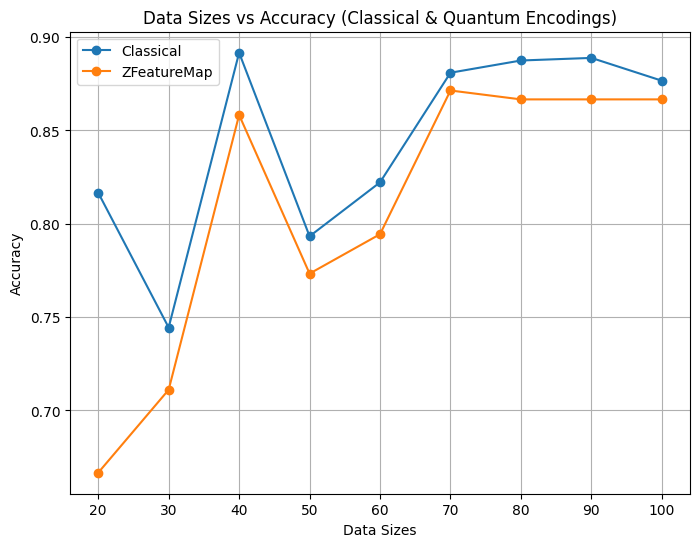

In [17]:
data_sizes, encodings, accuracies, times, mems = zip(*results)
unique_encodings = list(dict.fromkeys(encodings))  

plt.figure(figsize=(8,6))

for option in unique_encodings:
    x_vals = [s for s, e in zip(data_sizes, encodings) if e == option]
    y_vals = [a for a, e in zip(accuracies, encodings) if e == option]

    plt.plot(x_vals, y_vals, 'o-', label=option)

plt.xlabel("Data Sizes")
plt.ylabel("Accuracy")
plt.title("Data Sizes vs Accuracy (Classical & Quantum Encodings)")
plt.legend()
plt.grid(True)
plt.show()

## 6. Store data

In [19]:
platform = "pennylane"
record_folder = "Record Data"

os.makedirs(record_folder, exist_ok=True)

with open(os.path.join(record_folder, "time_executions.csv"), mode="a", newline="") as file:
    writer = csv.writer(file)
    for i, t in enumerate(times):
        if i%2 !=0: writer.writerow([platform, data_sizes[i], t])

with open(os.path.join(record_folder, "memory_usage.csv"), mode="a", newline="") as file:
    writer = csv.writer(file)
    for i, t in enumerate(mems):
        if i%2 !=0: writer.writerow([platform, data_sizes[i], t/1024/1024])